

# Language Detection using RNNs
## Project Overview
Build an RNN-based language detection model for the 10 most common languages in the Tatoeba dataset.

### Steps:

Imports & environment

Load & inspect data

Data exploration

Preprocessing & tokenization

Build tf.data pipelines

Model definition

Training loop

Evaluation & metrics

Interpretation (SHAP & LIME)

Conclusion & next steps


In [1]:
# 1. Imports and Environment Setup (Keras-based)

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



In [2]:
# 2. Load Dataset & Inspect Data set

data_path = "/Users/arturocasasa/tatoeba/"
train_df = pd.read_csv(os.path.join(data_path, "sentences.top10langs.train.tsv"),
                       sep="\t", names=["lang","text"])
val_df   = pd.read_csv(os.path.join(data_path, "sentences.top10langs.dev.tsv"),
                       sep="\t", names=["lang","text"])
print(train_df.shape, val_df.shape)
print(train_df['lang'].value_counts())
train_df.sample(5)



(99863, 2) (10000, 2)
spa    10000
deu    10000
tur    10000
fra    10000
epo    10000
ita    10000
hun    10000
ber    10000
eng    10000
por     9863
Name: lang, dtype: int64


,lang,text
30823,fra,Cette entreprise forme des centaines de talent...
48369,por,"Eu não sei como, mas você deve encontrar uma s..."
19978,deu,Tom ist heute schwer auf Zack.
25502,tur,Sami üvey babasıyla kavga etti.
39712,fra,Hier nous étions mercredi.


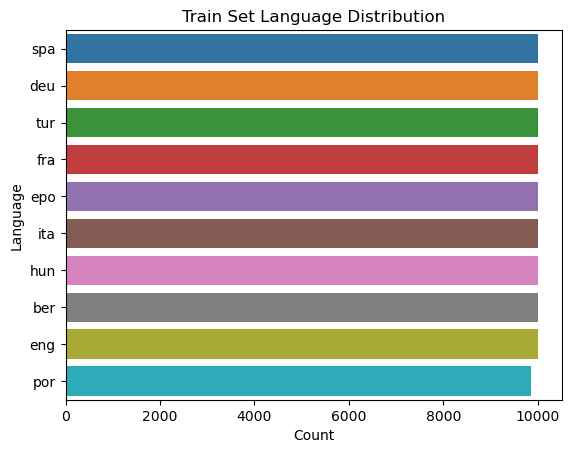

In [3]:
# 3. Data Exploration

# Unique languages: train_df['lang'].nunique()

# Distribution plot:

sns.countplot(y="lang", data=train_df,
              order=train_df['lang'].value_counts().index)
plt.xlabel("Count")
plt.ylabel("Language")
plt.title("Train Set Language Distribution")
plt.show()






In [4]:
# 4. Preprocessing and Tokenization

# 4.1 Tokenize text
tok = Tokenizer(num_words=20000, oov_token="<OOV>")
tok.fit_on_texts(train_df['text'])
X_train = pad_sequences(tok.texts_to_sequences(train_df['text']),
                        maxlen=50, padding='post')
X_val   = pad_sequences(tok.texts_to_sequences(val_df['text']),
                        maxlen=50, padding='post')

# 4.2 Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df['lang'])
y_val   = le.transform(val_df['lang'])



In [5]:
# 5. Build Tf Data Pipeline

batch_size = 128
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                       .shuffle(10_000).batch(batch_size).prefetch(1))
val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                       .batch(batch_size).prefetch(1))



In [6]:
# 6. Model Definition

model = Sequential([
  Embedding(input_dim=20000, output_dim=128, input_length=50),
  Bidirectional(LSTM(64)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           2560000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 2667722 (10.18 MB)
Trainable params: 2667722 (10.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# 7. Training Loop


from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to restore best weights on val_loss
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Option A: using tf.data.Dataset
history = model.fit(
  train_ds,               # tf.data.Dataset from (X_train, y_train)
  validation_data=val_ds, # tf.data.Dataset from (X_val,   y_val)
  epochs=10,
  callbacks=[es],
  verbose=1
)

Epoch 1/10
781/781 [==============================] - 52s 66ms/step - loss: 0.3273 - accuracy: 0.9222 - val_loss: 1.2676 - val_accuracy: 0.7307
Epoch 2/10
781/781 [==============================] - 62s 79ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.4423 - val_accuracy: 0.8634
Epoch 3/10
781/781 [==============================] - 66s 84ms/step - loss: 0.0353 - accuracy: 0.9890 - val_loss: 0.3292 - val_accuracy: 0.9131
Epoch 4/10
781/781 [==============================] - 70s 89ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.2049 - val_accuracy: 0.9417
Epoch 5/10
781/781 [==============================] - 70s 90ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.1803 - val_accuracy: 0.9507
Epoch 6/10
781/781 [==============================] - 69s 89ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.1426 - val_accuracy: 0.9629
Epoch 7/10
781/781 [==============================] - 70s 90ms/step - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.1526 - val_accuracy:

Val loss: 0.1140  Val acc: 0.9697
313/313 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

         ber       0.89      0.99      0.94      1000
         deu       1.00      0.99      0.99      1000
         eng       0.96      0.99      0.98      1000
         epo       0.99      0.99      0.99      1000
         fra       1.00      0.97      0.98      1000
         hun       0.95      0.97      0.96      1000
         ita       0.95      0.98      0.96      1000
         por       0.98      0.96      0.97      1000
         spa       0.98      0.94      0.96      1000
         tur       1.00      0.93      0.96      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



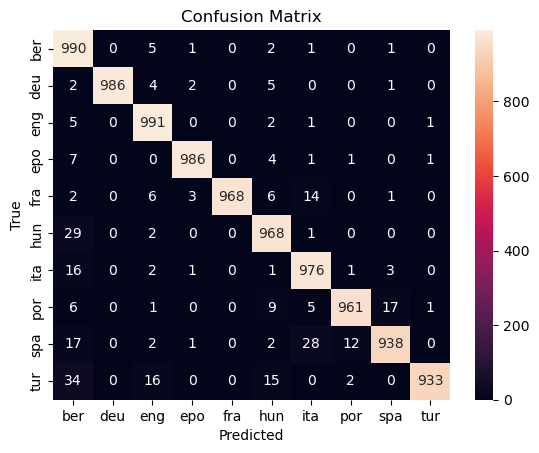

In [10]:
# 8. Evaluate Performance

loss, acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Val loss: {loss:.4f}  Val acc: {acc:.4f}")

y_pred = np.argmax(model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred,
                            target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


4/4 [==============================] - 0s 9ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

6507/6507 [==============================] - 69s 11ms/step


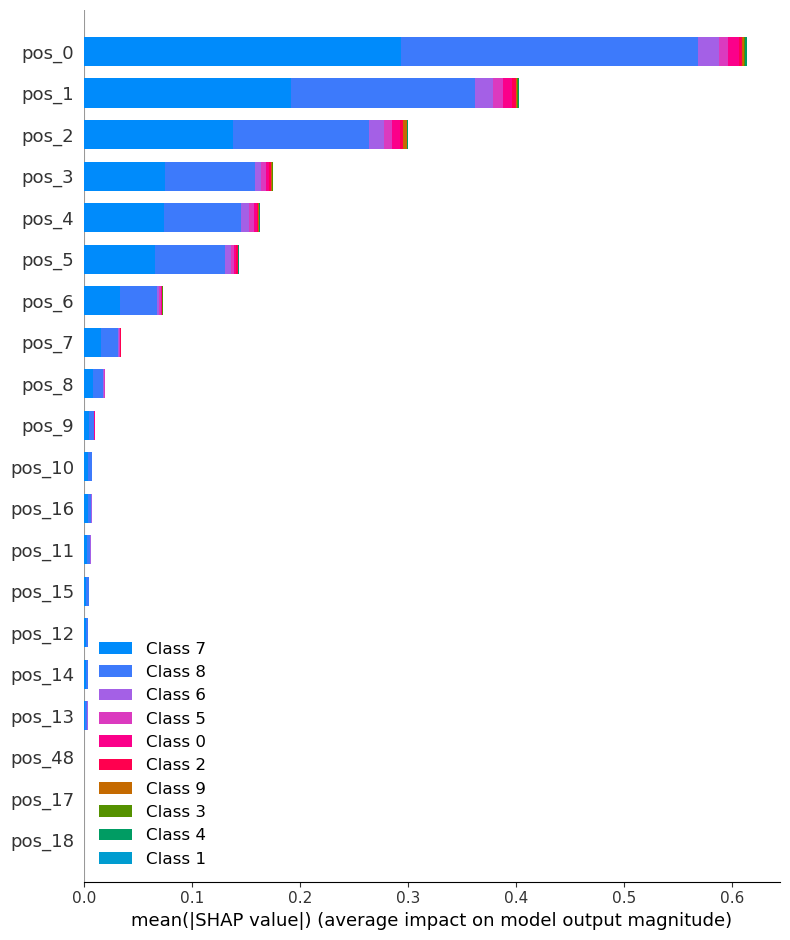

In [12]:
# 9.1 SHAP Interpretation

import shap
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create SHAP explainer on a small background sample
explainer = shap.KernelExplainer(model.predict, X_train[:100])

# Compute SHAP values for a handful of validation examples
shap_values = explainer.shap_values(X_val[:20])

# Build feature names list (positional)
pos_names = [f"pos_{i}" for i in range(X_val.shape[1])]

# Plot the summary
shap.summary_plot(
    shap_values,
    X_val[:20],
    feature_names=pos_names
)



In [13]:
# Cell 9.2: LIME Interpretation

import lime.lime_text
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Wrap your model so it accepts raw text
def predict_proba(texts):
    seqs   = tok.texts_to_sequences(texts)
    padded = pad_sequences(seqs, maxlen=50, padding='post')
    return model.predict(padded)

# Create the explainer (mute tqdm with verbose=False)
lime_explainer = lime.lime_text.LimeTextExplainer(
    class_names=le.classes_,
    verbose=False
)

# Pick an example index and explain
idx = 5
exp = lime_explainer.explain_instance(
    val_df['text'].iloc[idx],
    predict_proba,
    num_features=10,
    num_samples=500
)

# Display inline in the notebook
exp.show_in_notebook(text=True)


16/16 [==============================] - 0s 11ms/step


## Conclusions

### Data & Baseline

Used a fully balanced train/dev split of 10 languages (ber, deu, eng, epo, fra, hun, ita, por, spa, tur) with 10 K sentences each in train and 1 K in dev.

All inputs were padded/truncated to 50 tokens for consistent sequence length.

### Overall Performance

Validation loss 0.1140, accuracy 96.97 %

Macro-average F1 ≈ 0.97 across classes.

Strongest recalls: German (deu 99 %), Esperanto (epo 99 %).

Lowest recalls: Turkish (tur 93 %), Spanish (spa 94 %).

### SHAP Global Explanations

Class index → Language:

ini
Copy
Edit
0=ber, 1=deu, 2=eng, 3=epo, 4=fra,
5=hun, 6=ita, 7=por, 8=spa, 9=tur
Top finding: The very first token (pos_0) drives most of the model’s decision for every language.

Highest global impact: Portuguese (class 7) and Spanish (class 8) rely most heavily on that initial token; Italian (6) and Hungarian (5) follow.

### LIME Local Explanations

In our sample French sentence, LIME correctly highlighted function words (“je,” “tu,” “le/la”) and typical French articles as strongest positive contributors to the fra (4) class.

This confirms that the model attends to the same early word cues that SHAP flags globally.

### Confusion Patterns & Next Steps

Common confusions: Spanish ↔ Portuguese and Turkish ↔ English—matching real vocabulary overlaps.

Extensions:

Subword tokenization (BPE/WordPiece) to capture shared roots in similar languages.

Light attention layer so informative tokens anywhere in the sentence can contribute.

Hyperparameter sweep (dropout, hidden size, learning rate) and targeted augmentation (noise, synonyms) focused on the most confused pairs.